In [1]:
import pandas as pd
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split

In [2]:
# user = pd.read_csv('BX-Users.csv', sep=';', error_bad_lines=False, encoding="latin-1")
# user.columns = ['userID', 'Location', 'Age']
df = pd.read_csv('data/ml-latest-small/ratings.csv', error_bad_lines=False, encoding="latin-1")
df.columns = ['userID', 'movieId', 'rating', 'timestamp']
df = df[['userID', 'movieId', 'rating']]
df

,userID,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0


In [26]:
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(df[['userID', 'movieId', 'rating']], reader)

In [ ]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=5, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)

In [28]:
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values(by='test_rmse')

In [29]:
global_mean_rmse = 1.0425387457156323
mom_mean_rmse = 0.9307372963743497


In [30]:
surprise_results['%_Improvement_Over_GlobalMean'] = ((global_mean_rmse-surprise_results['test_rmse'])/global_mean_rmse)*100
surprise_results['%_Improvement_Over_MeanOfMeans'] = ((mom_mean_rmse-surprise_results['test_rmse'])/mom_mean_rmse)*100
surprise_results.rename(columns={'test_rmse': '5-Fold_CrossVal_RMSE', 
                         'fit_time': 'Fit_Time', 'test_time': 'Test_Time'}, 
                             inplace=True)
cols = ['5-Fold_CrossVal_RMSE', '%_Improvement_Over_GlobalMean', '%_Improvement_Over_MeanOfMeans',
            'Fit_Time', 'Test_Time']
surprise_results = surprise_results[cols]

In [31]:
surprise_results

In [60]:
print('Using ALS')
bsl_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 12,
               'reg_i': 5
               }
algo = BaselineOnly(bsl_options=bsl_options)
cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)

Using ALS
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


{'fit_time': (0.03386187553405762, 0.030477523803710938, 0.031255483627319336),
 'test_rmse': array([0.84646138, 0.82879391, 0.83299154]),
 'test_time': (0.05475640296936035, 0.06729912757873535, 0.12399768829345703)}

In [61]:

trainset, testset = train_test_split(data, test_size=0.25)
algo = BaselineOnly(bsl_options=bsl_options)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

Estimating biases using als...
RMSE: 0.8357


0.835711234426588

In [62]:
trainset = algo.trainset
print(algo.__class__.__name__)

BaselineOnly


In [63]:
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)

In [64]:
df.head()

,uid,iid,rui,est,details,Iu,Ui,err
0,68,72998,5.0,3.232694,{'was_impossible': False},281,64,1.767306
1,380,377,5.0,3.888299,{'was_impossible': False},212,102,1.111701
2,234,2355,5.0,3.753376,{'was_impossible': False},50,69,1.246624
3,240,589,4.0,4.486805,{'was_impossible': False},52,133,0.486805
4,587,2396,5.0,4.165559,{'was_impossible': False},45,62,0.834441


In [65]:
best_predictions = df.sort_values(by='err')[:10]
worst_predictions = df.sort_values(by='err')[-10:]

In [66]:
best_predictions


,uid,iid,rui,est,details,Iu,Ui,err
3133,306,50872,3.5,3.499907,{'was_impossible': False},16,45,0.000093
1255,313,780,3.0,3.000123,{'was_impossible': False},116,134,0.000123
1654,168,1276,4.5,4.500176,{'was_impossible': False},25,40,0.000176
4114,514,457,4.0,3.999578,{'was_impossible': False},113,114,0.000422
2728,384,457,4.0,4.000617,{'was_impossible': False},19,114,0.000617
8695,509,1917,3.0,2.999357,{'was_impossible': False},97,50,0.000643
4253,219,1221,4.0,4.000754,{'was_impossible': False},188,85,0.000754
785,219,296,4.0,4.000797,{'was_impossible': False},188,178,0.000797
4261,105,4963,4.0,4.000804,{'was_impossible': False},135,87,0.000804
8916,377,2858,4.5,4.500840,{'was_impossible': False},23,131,0.000840


In [67]:
worst_predictions

,uid,iid,rui,est,details,Iu,Ui,err
5634,111,593,0.5,3.893930,{'was_impossible': False},94,169,3.393930
3897,551,6874,0.5,3.924800,{'was_impossible': False},48,88,3.424800
2522,524,318,1.0,4.442742,{'was_impossible': False},62,182,3.442742
5800,413,1246,1.0,4.447047,{'was_impossible': False},33,54,3.447047
5291,51,3253,0.5,3.950478,{'was_impossible': False},81,43,3.450478
4697,393,74458,0.5,4.108526,{'was_impossible': False},51,36,3.608526
2503,239,48394,0.5,4.208453,{'was_impossible': False},153,54,3.708453
4486,393,589,0.5,4.225596,{'was_impossible': False},51,133,3.725596
7448,344,3949,0.5,4.233482,{'was_impossible': False},39,68,3.733482
5383,393,1732,0.5,4.306219,{'was_impossible': False},51,73,3.806219


In [68]:
df_new.loc[df_new['movieId'] == '168248']['rating'].describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: rating, dtype: float64

In [71]:
df_new.loc[df_new['movieId'] == 1]['rating'].describe()

count    173.000000
mean       3.884393
std        0.827183
min        0.500000
25%        3.500000
50%        4.000000
75%        4.500000
max        5.000000
Name: rating, dtype: float64

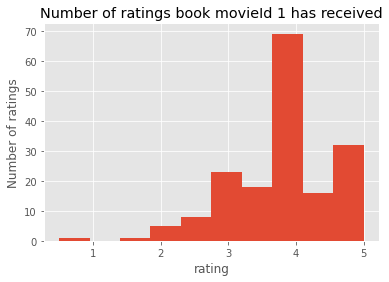

In [81]:
import matplotlib.pyplot as plt
%matplotlib inline

df_new.loc[df_new['movieId'] == 1]['rating'].hist()
plt.xlabel('rating')
plt.ylabel('Number of ratings')
plt.title('Number of ratings book movieId 1 has received')
plt.show();